In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Ingestion

Let's see how we can get the images from the data directory.

In [2]:
!tree -d /kaggle/input

/kaggle/input
└── tire-texture-image-recognition
    └── Tire Textures
        ├── testing_data
        │   ├── cracked
        │   └── normal
        └── training_data
            ├── cracked
            └── normal

8 directories


In [3]:
import os
TRAIN_DIR_LOCATION = '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data'
TEST_DIR_LOCATION = '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data'

for dirname, directories, filenames in os.walk(TRAIN_DIR_LOCATION):
    print(f"There are {len(directories)} directories and {len(filenames)} files in '{dirname}'.")
    
print("============================================================================================================================")
for dirname, directories, filenames in os.walk(TEST_DIR_LOCATION):
    print(f"There are {len(directories)} directories and {len(filenames)} files in '{dirname}'.")

There are 2 directories and 0 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data'.
There are 0 directories and 327 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data/cracked'.
There are 0 directories and 376 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data/normal'.
There are 2 directories and 0 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data'.
There are 0 directories and 210 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data/cracked'.
There are 0 directories and 115 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data/normal'.


# Expoloratory Data Analysis

In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_random_image(target_set, target_class):
    folder = os.path.join(target_set, target_class)
    image_path = random.sample(os.listdir(folder), 1)
    print(folder)
    print(image_path)
    
    img = mpimg.imread(os.path.join(folder, image_path[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    print(img.shape)

/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data/cracked
['Cracked-375.jpg']
(447, 447, 3)


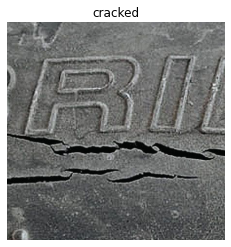

In [5]:
show_random_image(TRAIN_DIR_LOCATION, 'cracked')

# Data Pre-processing

We use the Tensorflow's ImageDataGenerator to retrieve the train and validation data from the directory.

In [6]:
import tensorflow as tf

tf.random.set_seed(42)
# PIXEL_SIZE = (512, 512)
PIXEL_SIZE = (224, 224)

# normalize the pixel values
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data = train_img_gen.flow_from_directory(TRAIN_DIR_LOCATION,
                                  #resize the images for uniformity and less data
                                  target_size=PIXEL_SIZE,
                                  batch_size=32,
                                  class_mode='binary',
                                  seed=42)

# do the same for validation data
valid_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_data = train_img_gen.flow_from_directory(TEST_DIR_LOCATION,
                                  #resize the images for uniformity and less data
                                  target_size=PIXEL_SIZE,
                                  batch_size=32,
                                  class_mode='binary',
                                  seed=42)

Found 703 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


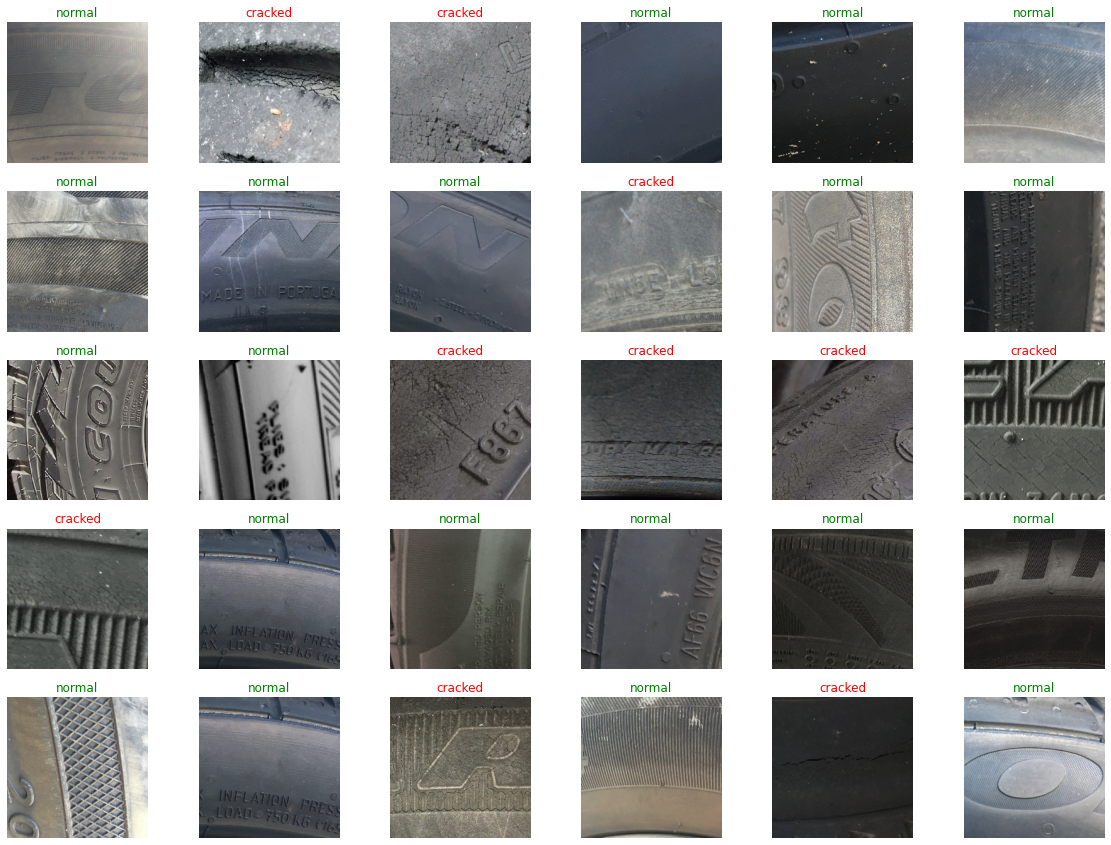

In [7]:
def show_images(images, labels):
    row_count = 5
    col_count = 6
    fig, axs = plt.subplots(row_count, col_count, figsize=(20, 15))
    for index, image in enumerate(images[:30]):
        row = index // col_count
        col = index % col_count
        label = labels[index]
        
        axs[row, col].imshow(image)
        axs[row, col].set_title(label,
                               fontdict={
                                   'color': 'green' if label == 'normal' else 'red'
                               })
        axs[row, col].axis('off')
    plt.show()
    
class_lookup = {v:k for k,v in train_data.class_indices.items()}
labels = [class_lookup[int(x)] for x in train_data[0][1]]
show_images(train_data[0][0],labels)

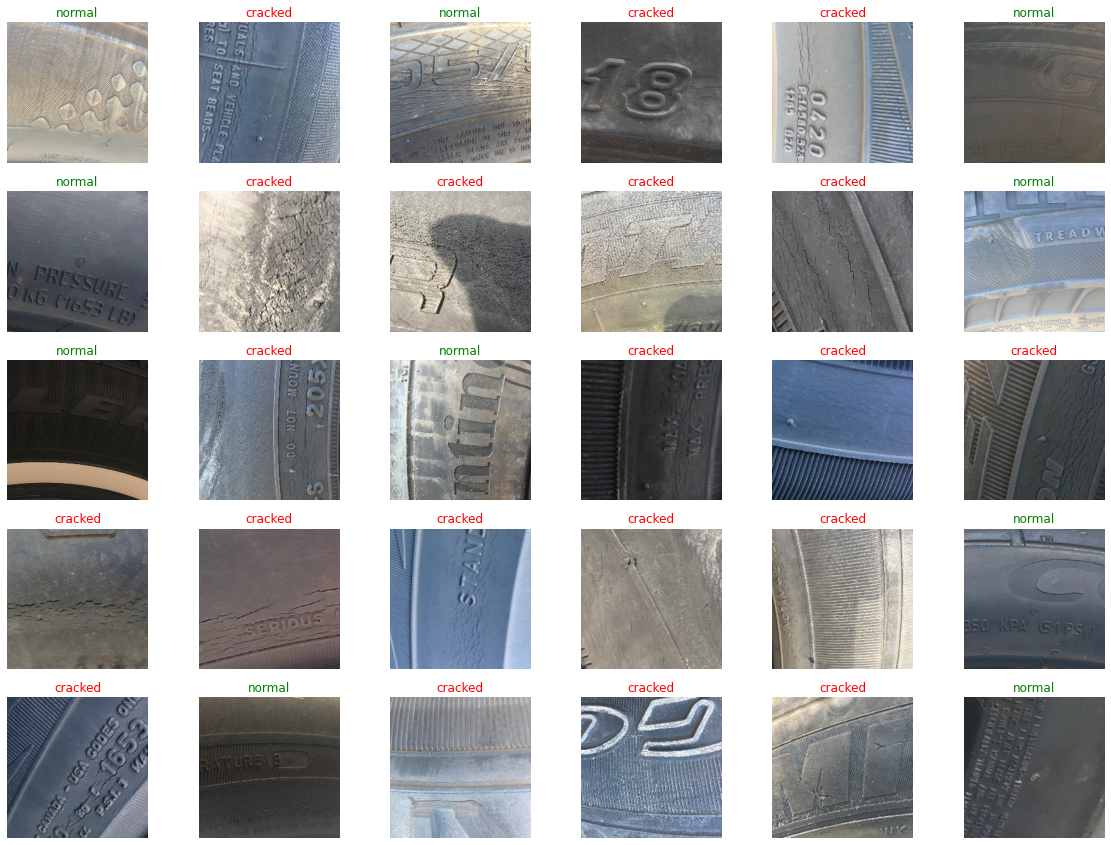

In [8]:
labels = [class_lookup[int(x)] for x in valid_data[0][1]]
show_images(valid_data[0][0],labels)

# Modelling

## Baseline model - 1 convolutional layer

In [9]:
import tensorflow as tf

def create_baseline_model(train_data, valid_data):
    tf.random.set_seed(42)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10, 
                               kernel_size=3,
                               activation='relu',
                               input_shape=(PIXEL_SIZE[0], PIXEL_SIZE[1], 3)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    history = model.fit(train_data, 
                        epochs=10,
                        steps_per_epoch=len(train_data), 
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        verbose=0)
    
    return (model, history.history)

In [10]:
MODEL_DIR = "/kaggle/working/models"
HISTORY_DIR = "/kaggle/working/history"

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
if not os.path.exists(HISTORY_DIR):
    os.mkdir(HISTORY_DIR)

In [11]:
def load_baseline_model(train_data, valid_data, forced=False):
    MODEL_FILE = f"{MODEL_DIR}/baseline_model"
    HISTORY_FILE = f"{HISTORY_DIR}/baseline_model"
    if os.path.exists(MODEL_FILE) and not forced:
        print("Loading baseline model...")
        model = tf.keras.models.load_model(MODEL_FILE)
        history = pd.read_csv(HISTORY_FILE)
        return (model, history)
    else:
        print("Creating baseline model...")
        (model, history) = create_baseline_model(train_data, valid_data)
        
        model.save(MODEL_FILE)
        pd.DataFrame(history).to_csv(HISTORY_FILE)
        return (model, history)

baseline_model, baseline_history = load_baseline_model(train_data, valid_data)

Creating baseline model...


2023-02-05 04:36:53.804322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 04:36:53.805374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 04:36:53.982798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 04:36:53.983673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 04:36:53.984395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

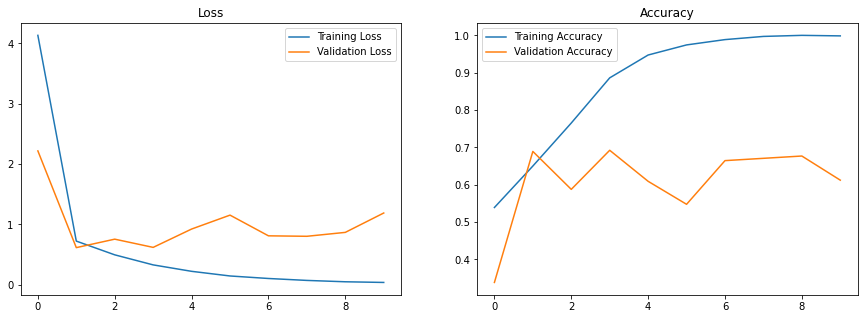

In [12]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    loss = history["loss"]
    val_loss = history["val_loss"]
    axs[0].plot(loss, label="Training Loss")
    axs[0].plot(val_loss, label="Validation Loss")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    accuracy = history["accuracy"]
    val_accuracy = history["val_accuracy"]
    axs[1].plot(accuracy, label="Training Accuracy")
    axs[1].plot(val_accuracy, label="Validation Accuracy")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
plot_history(baseline_history)

## Model 1 - convolutional + max pooling layers

In [13]:
def create_model1(train_data, valid_data):
    tf.random.set_seed(42)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(10, 3, 
                               activation="relu", 
                               input_shape=(PIXEL_SIZE[0], PIXEL_SIZE[1], 3)),
        tf.keras.layers.MaxPool2D(2),

        tf.keras.layers.Conv2D(10, 3, activation="relu"),
        tf.keras.layers.MaxPool2D(2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    history = model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        verbose=0)
    
    return (model, history.history)

In [14]:
def load_model1(train_data, valid_data, forced=False):
    MODEL_FILE = f"{MODEL_DIR}/model1"
    HISTORY_FILE = f"{HISTORY_DIR}/model1"
    if os.path.exists(MODEL_FILE) and not forced:
        print("Loading model_1...")
        model = tf.keras.models.load_model(MODEL_FILE)
        history = pd.read_csv(HISTORY_FILE)
        return (model, history)
    else:
        print("Creating model_1...")
        (model, history) = create_model1(train_data, valid_data)
        
        model.save(MODEL_FILE)
        pd.DataFrame(history).to_csv(HISTORY_FILE)
        return (model, history)

model_1, model1_history = load_model1(train_data, valid_data)

Creating model_1...


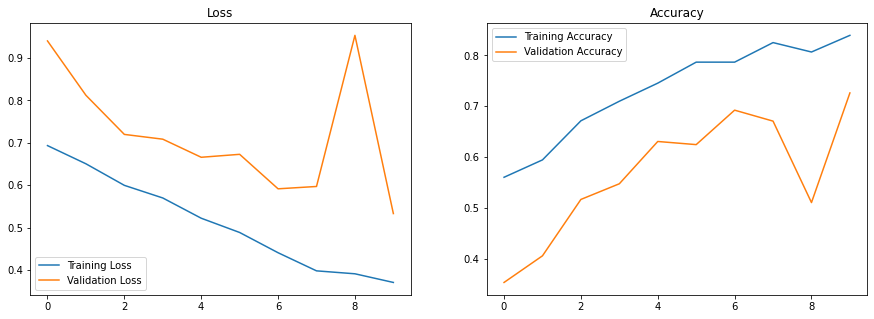

In [15]:
plot_history(model1_history)

## Model 2 - train with augmented data

Found 703 images belonging to 2 classes.


(224, 224, 3)

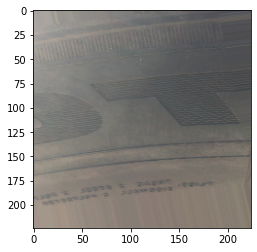

In [16]:
augmented_train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

augmented_train_data = augmented_train_img_gen.flow_from_directory(
    TRAIN_DIR_LOCATION,
    target_size=PIXEL_SIZE,
    class_mode="binary",
    seed=42)

plt.imshow(augmented_train_data[0][0][0])
augmented_train_data[0][0][0].shape

In [17]:
def create_model2(train_data, valid_data):
    tf.random.set_seed(42)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=10, 
                               kernel_size=3,
                               activation='relu',
                               input_shape=(PIXEL_SIZE[0], PIXEL_SIZE[1], 3)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    history = model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        verbose=0)
    
    return (model, history.history)

In [18]:
def load_model2(train_data, valid_data, forced=False):
    MODEL_FILE = f"{MODEL_DIR}/model2"
    HISTORY_FILE = f"{HISTORY_DIR}/model2"
    if os.path.exists(MODEL_FILE) and not forced:
        print("Loading model_2...")
        model = tf.keras.models.load_model(MODEL_FILE)
        history = pd.read_csv(HISTORY_FILE)
        return (model, history)
    else:
        print("Creating model_2...")
        (model, history) = create_model2(train_data, valid_data)
        
        model.save(MODEL_FILE)
        pd.DataFrame(history).to_csv(HISTORY_FILE)
        return (model, history)

model_2, model2_history = load_model2(augmented_train_data, valid_data)

Creating model_2...


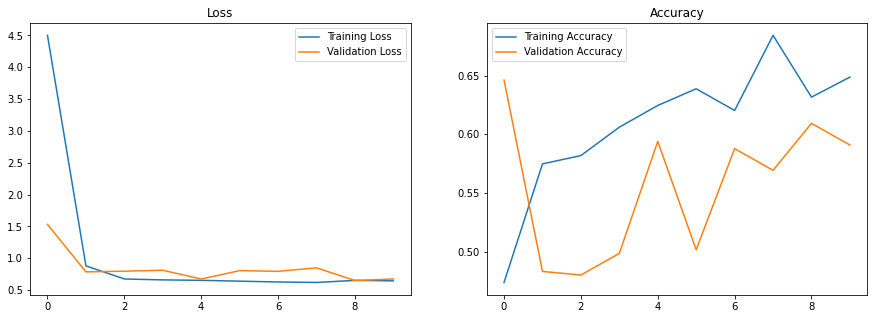

In [19]:
plot_history(model2_history)

## Model 3 - combination of max pool and augmented data

In [20]:
def create_model3(train_data, valid_data):
    tf.random.set_seed(42)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=100, 
                               kernel_size=3,
                               activation='relu',
                               input_shape=(PIXEL_SIZE[0], PIXEL_SIZE[1], 3)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    history = model.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        verbose=0)
    
    return (model, history.history)

In [21]:
def load_model3(train_data, valid_data, forced=False):
    MODEL_FILE = f"{MODEL_DIR}/model3"
    HISTORY_FILE = f"{HISTORY_DIR}/model3"
    if os.path.exists(MODEL_FILE) and not forced:
        print("Loading model_3...")
        model = tf.keras.models.load_model(MODEL_FILE)
        history = pd.read_csv(HISTORY_FILE)
        return (model, history)
    else:
        print("Creating model_3...")
        (model, history) = create_model2(train_data, valid_data)
        
        model.save(MODEL_FILE)
        pd.DataFrame(history).to_csv(HISTORY_FILE)
        return (model, history)

model_3, model3_history = load_model3(augmented_train_data, valid_data)

Creating model_3...


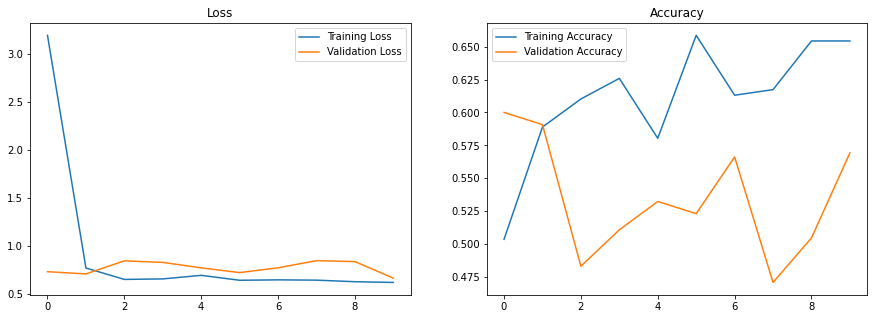

In [22]:
plot_history(model3_history)

In [23]:
def create_model4(train_data, valid_data):
    tf.random.set_seed(42)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=100, 
                               kernel_size=3,
                               activation='relu',
                               input_shape=(PIXEL_SIZE[0], PIXEL_SIZE[1], 3)),
        tf.keras.layers.Conv2D(100,3),
        tf.keras.layers.MaxPool2D(2),
        
        tf.keras.layers.Conv2D(100,3),
        tf.keras.layers.Conv2D(100,3),
        tf.keras.layers.MaxPool2D(2),
        
        
        tf.keras.layers.Conv2D(100,3),
        tf.keras.layers.Conv2D(100,3),
        tf.keras.layers.MaxPool2D(2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    history = model.fit(train_data,
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        verbose=1)
    
    return (model, history.history)

In [24]:
# model4, model4_history = create_model4(augmented_train_data, valid_data)

In [25]:
# plot_history(model4_history)